In [2]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, median_absolute_error
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestRegressor
import numpy as np
import seaborn as sns

In [3]:
df = pd.read_csv('realtor-data.zip.csv')

In [4]:
df.head()

,brokered_by,status,price,bed,bath,acre_lot,street,city,state,zip_code,house_size,prev_sold_date
0,103378.0,for_sale,105000.0,3.0,2.0,0.12,1962661.0,Adjuntas,Puerto Rico,601.0,920.0,NaN
1,52707.0,for_sale,80000.0,4.0,2.0,0.08,1902874.0,Adjuntas,Puerto Rico,601.0,1527.0,NaN
2,103379.0,for_sale,67000.0,2.0,1.0,0.15,1404990.0,Juana Diaz,Puerto Rico,795.0,748.0,NaN
3,31239.0,for_sale,145000.0,4.0,2.0,0.10,1947675.0,Ponce,Puerto Rico,731.0,1800.0,NaN
4,34632.0,for_sale,65000.0,6.0,2.0,0.05,331151.0,Mayaguez,Puerto Rico,680.0,NaN,NaN


In [5]:
df = df[df['status'] == 'sold']

In [6]:
city_counts = df['city'].value_counts()

valid_cities = city_counts[city_counts > 5000].index 
valid_cities

Index(['Houston', 'Tucson', 'Jacksonville', 'Chicago', 'Dallas', 'Richmond',
       'Charlotte', 'San Diego'],
      dtype='object', name='city')

In [7]:
fdf = df[df['city'].isin(valid_cities)]
fdf = fdf.reset_index(drop=True)

len(fdf)

50762

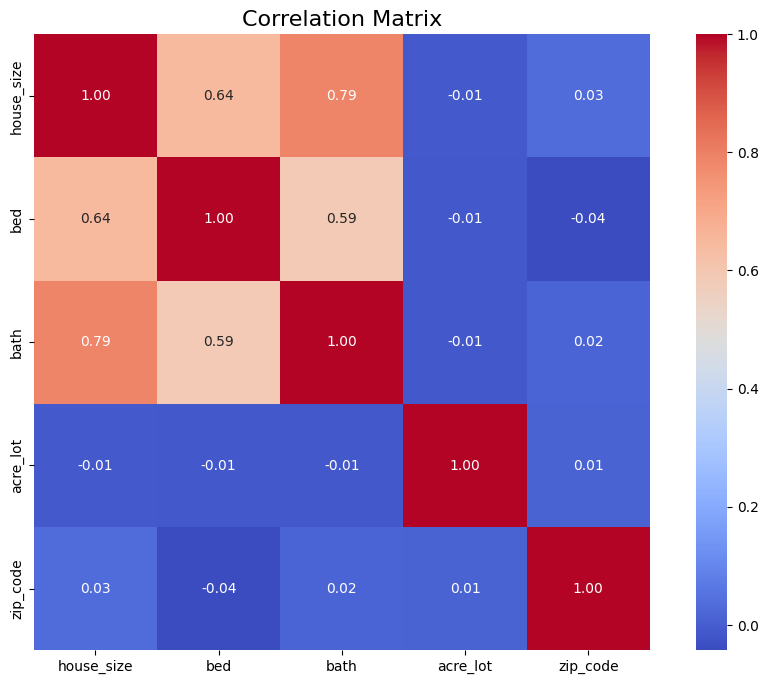

In [10]:
selected_columns = ['house_size', 'bed', 'bath', 'acre_lot', 'zip_code']
filtered_df = fdf[selected_columns]
correlation_matrix = filtered_df.corr()

# Set up the matplotlib figure
plt.figure(figsize=(12, 8))

# Draw the heatmap
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True, square=True)

# Add titles
plt.title("Correlation Matrix", fontsize=16)
plt.show()

In [ ]:
fdf.head()

,brokered_by,status,price,bed,bath,acre_lot,street,city,state,zip_code,house_size,prev_sold_date
0,94681.0,sold,229900.0,2.0,1.0,0.16,602381.0,Richmond,Massachusetts,1254.0,528.0,2022-03-21
1,94681.0,sold,1100000.0,4.0,3.0,9.02,1520769.0,Richmond,Massachusetts,1254.0,2700.0,2021-11-01
2,94681.0,sold,349900.0,3.0,1.0,0.32,475836.0,Richmond,Massachusetts,1254.0,816.0,2021-10-22
3,96714.0,sold,149900.0,2.0,1.0,3.20,741345.0,Richmond,Massachusetts,1254.0,1155.0,2022-01-06
4,21935.0,sold,995000.0,4.0,3.0,2.30,1421661.0,Richmond,Massachusetts,1254.0,2464.0,2022-03-03


In [ ]:
fdf = fdf.drop(columns=['brokered_by', 'status', 'street'])

In [ ]:
def plot_actual_vs_predicted(y_test, predictions):
    plt.figure(figsize=(10, 6))
    plt.scatter(y_test, predictions, alpha=0.5, color='blue', label='Predicted vs. Actual')
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2, label='Ideal Fit')
    plt.title('Actual Prices vs. Predicted Prices')
    plt.xlabel('Actual Prices')
    plt.ylabel('Predicted Prices')
    plt.legend()
    plt.grid(True)
    plt.show()

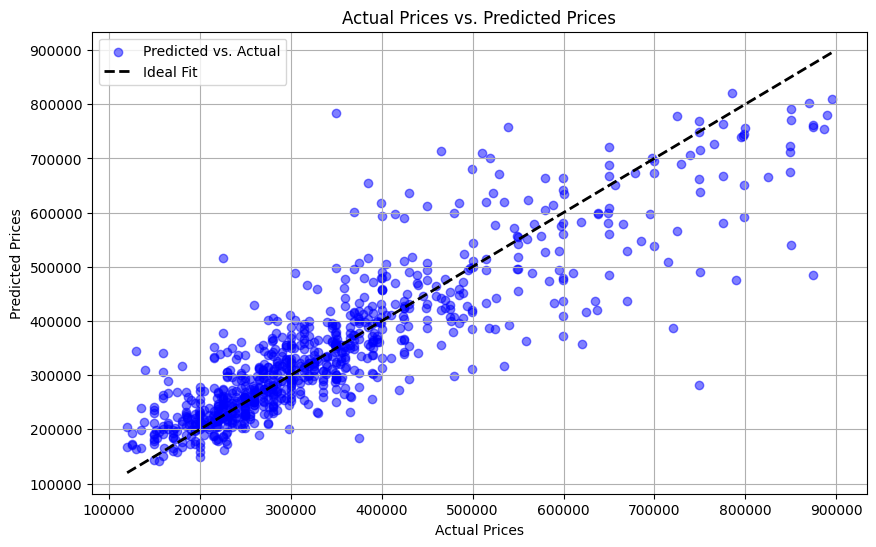

Mean Squared Error: 5756671981.713645
Mean Absolute Error: 50642.928120316334
Median Absolute Error: 33420.73999999999
25th Percentile Error: 14201.242499999993
75th Percentile Error: 64936.91499999995
Mean Absolute Percentage Error: 15.284753666504368
R2: 0.7641062084500799


In [ ]:
def regress_estate_properties(df, feature_cols, city):
    # Filter data for the specified city
    df = df[df['city'] == city]
    
    # Remove price outliers based on percentiles
    lower_bound = df['price'].quantile(0.025)
    upper_bound = df['price'].quantile(0.975)
    df = df[(df['price'] > lower_bound) & (df['price'] < upper_bound)]
    
    if 'zip_code' in feature_cols:
        df = pd.get_dummies(df, columns=['zip_code'], prefix='zip')
        # Update feature_cols to include the new one-hot encoded columns
        feature_cols = [col for col in df.columns if col.startswith('zip_') or col in feature_cols]
    
    # Drop rows where any of the selected features are NaN
    clean_df = df.dropna(subset=feature_cols)
    
    # Drop rows where any of the selected features are NaN
    clean_df = df.dropna(subset=feature_cols)
    
    # Split the data into features and target
    X = clean_df[feature_cols]
    y = clean_df['price']
    
    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Create a random forest regression model
    model = RandomForestRegressor(n_estimators=100, random_state=42)
    
    # Fit the model
    model.fit(X_train, y_train)
    
    # Make predictions on the test set
    predictions = model.predict(X_test)
    
    # Calculate the mean squared error and R^2 score
    mse = mean_squared_error(y_test, predictions)
    mae = mean_absolute_error(y_test, predictions)
    med_ae = median_absolute_error(y_test, predictions)
    
    # Calculate error percentiles
    errors = np.abs(y_test - predictions)
    percentile_25 = np.percentile(errors, 25)
    percentile_75 = np.percentile(errors, 75)
    percentage_errors = 100 * (errors / y_test)
    mean_absolute_percentage_error = np.mean(percentage_errors)
    
    # Plotting the actual vs predicted prices
    plot_actual_vs_predicted(y_test, predictions)
    
    # Return the model and its metrics
    print("Mean Squared Error:", mse)
    print("Mean Absolute Error:", mae)
    print("Median Absolute Error:", med_ae)
    print("25th Percentile Error:", percentile_25)
    print("75th Percentile Error:", percentile_75)
    print("Mean Absolute Percentage Error:", mean_absolute_percentage_error)
    print("R2:", r2_score(y_test, predictions))


regress_estate_properties(fdf, ['house_size', 'bed', 'bath', 'acre_lot', 'zip_code'], 'Richmond')


In [ ]:
def predict_estate_price(df, city, input_features: dict):
    # Filter data for the specified city
    df = df[df['city'] == city]
    
    # Remove price outliers based on percentiles
    lower_bound = df['price'].quantile(0.025)
    upper_bound = df['price'].quantile(0.975)
    df = df[(df['price'] > lower_bound) & (df['price'] < upper_bound)]
    
    feature_cols = input_features.keys()
    
    if 'zip_code' in feature_cols:
        df = pd.get_dummies(df, columns=['zip_code'], prefix='zip')
        # Update feature_cols to include the new one-hot encoded columns
        feature_cols = [col for col in df.columns if col.startswith('zip_') or col in feature_cols]
        # One-hot encode the input features for zip_code
        zip_code_col = f"zip_{input_features['zip_code']}"
        for col in feature_cols:
            if col.startswith("zip_") and col not in input_features:
                input_features[col] = 0  # Set missing zip codes to 0
        input_features[zip_code_col] = 1  # Set the input zip code to 1

    # Drop rows where any of the selected features are NaN
    clean_df = df.dropna(subset=feature_cols)
    
    # Split the data into features and target
    X = clean_df[feature_cols]
    y = clean_df['price']
    
    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Create a random forest regression model
    model = RandomForestRegressor(n_estimators=100, random_state=42)
    
    # Fit the model
    model.fit(X_train, y_train)
    
    # Make predictions on the test set
    predictions = model.predict(X_test)
    
    # Calculate MAPE on the test set
    errors = np.abs(y_test - predictions)
    percentage_errors = 100 * (errors / y_test)
    mean_absolute_percentage_error = np.mean(percentage_errors)
    
    # Prepare the input features as a DataFrame
    input_data = pd.DataFrame([input_features])
    input_prediction = model.predict(input_data[feature_cols])[0]
    
    # Return the predicted price and confidence
    return {
        'predicted_price': input_prediction,
        'confidence_mape': mean_absolute_percentage_error
    }

In [ ]:
# Specify the feature columns and city
city = 'Richmond'

# Specify the input features for prediction
input_features = {
    # 'house_size': 2500,
    'bed': 4,
    # 'bath': 3,
    # 'acre_lot': 0.5,
    'zip_code': 23220  # This must match the zip codes in the dataset
}

# Predict the price and confidence
result = predict_estate_price(fdf, city, input_features)
print("Predicted Price:", result['predicted_price'])
print("Model Confidence (MAPE):", result['confidence_mape'])


Predicted Price: 358728.9863862947
Model Confidence (MAPE): 22.800759944084188
